## Loading the Housing dataset into a data frame

In [1]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/rasbt/python-machine-learning-book-2nd-edition/master/code/ch10/housing.data.txt',header=None,sep='\s+')
df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS','NOX', 'RM', 'AGE', 'DIS', 'RAD','TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


## Visulaizing the important characteristics of a dataset

C:\Users\ankit19.gupta\OneDrive - Reliance Corporate IT Park Limited\Desktop\Self_Projects\Python_Machine_Learning_Sebastian_Raschka\myenv\lib\site-packages\seaborn\axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


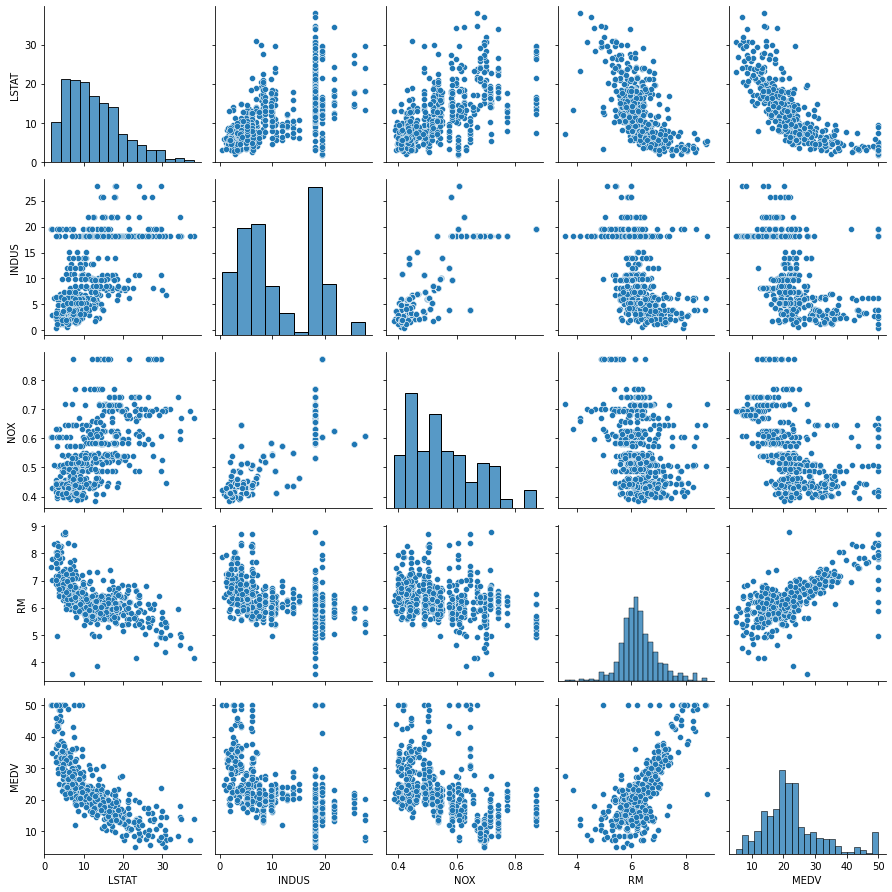

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']
sns.pairplot(df[cols], size=2.5)
plt.tight_layout()
plt.show()

## Looking at relationships using a correlation matrix

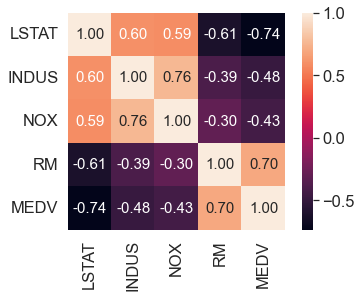

In [5]:
import numpy as np
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,cbar=True,annot=True,square=True,fmt='.2f',annot_kws={'size': 15},yticklabels=cols,xticklabels=cols)
plt.show()

## Implementing an ordinary least squares linear regression model

## Solving regression for regression parameters with gradient descent

In [6]:
class LinearRegressionGD(object):
    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta
        self.n_iter = n_iter
    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    def predict(self, X):
        return self.net_input(X)

In [7]:
X = df[['RM']].values
y = df['MEDV'].values
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()
lr = LinearRegressionGD()
lr.fit(X_std, y_std)

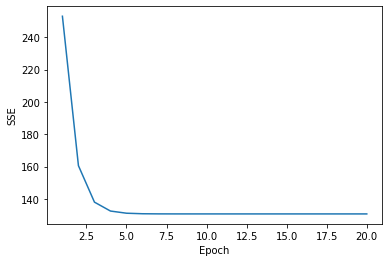

In [8]:
sns.reset_orig() # resets matplotlib style
plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.show()

In [9]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)
    return None

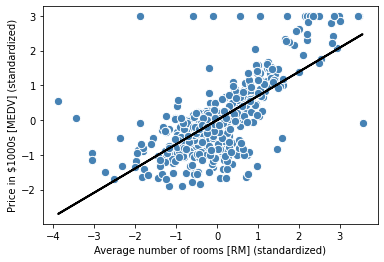

In [10]:
lin_regplot(X_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000s [MEDV] (standardized)')
plt.show()

In [15]:
# num_rooms_std = sc_x.transform([5.0])
# price_std = lr.predict(num_rooms_std)
# print("Price in $1000s: %.3f" % sc_y.inverse_transform(price_std))

In [16]:
print('Slope: %.3f' % lr.w_[1])
print('Intercept: %.3f' % lr.w_[0])

Slope: 0.695
Intercept: -0.000


## Estimating coefficients of the Regression model via scikit-learn

In [18]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X, y)
print('Slope: %.3f' % slr.coef_[0])

Slope: 9.102


In [19]:
print('Intercept: %.3f' % slr.intercept_)

Intercept: -34.671


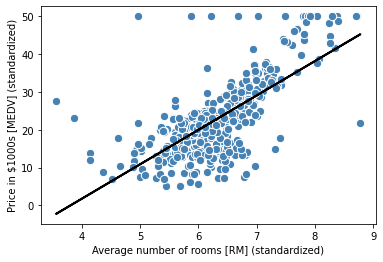

In [20]:
lin_regplot(X, y, slr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000s [MEDV] (standardized)')
plt.show()

In [21]:
# adding a column vector of "ones"
Xb = np.hstack((np.ones((X.shape[0], 1)), X))
w = np.zeros(X.shape[1])
z = np.linalg.inv(np.dot(Xb.T, Xb))
w = np.dot(z, np.dot(Xb.T, y))
print('Slope: %.3f' % w[1])
print('Intercept: %.3f' % w[0])

Slope: 9.102
Intercept: -34.671


## Fitting a robust regression model using RANSAC

In [22]:
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(LinearRegression(),max_trials=100,min_samples=50,loss='absolute_loss',residual_threshold=5.0,random_state=0)
ransac.fit(X, y)

RANSACRegressor(base_estimator=LinearRegression(), min_samples=50,
                random_state=0, residual_threshold=5.0)

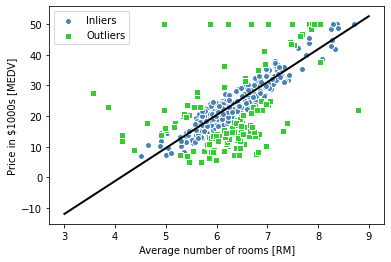

In [23]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],c='steelblue', edgecolor='white',marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],c='limegreen', edgecolor='white',marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='upper left')
plt.show()

In [24]:
print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_)

Slope: 10.735
Intercept: -44.089


## Evaluating the performance of linear regression models

In [25]:
from sklearn.model_selection import train_test_split
X = df.iloc[:, :-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

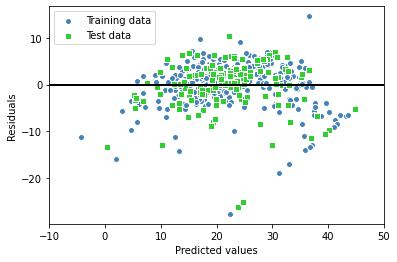

In [26]:
plt.scatter(y_train_pred, y_train_pred - y_train,
c='steelblue', marker='o', edgecolor='white',label='Training data')
plt.scatter(y_test_pred, y_test_pred - y_test,c='limegreen', marker='s', edgecolor='white',label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2)
plt.xlim([-10, 50])
plt.show()

In [27]:
from sklearn.metrics import mean_squared_error
print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred),mean_squared_error(y_test, y_test_pred)))

MSE train: 19.958, test: 27.196


In [28]:
from sklearn.metrics import r2_score
print('R^2 train: %.3f, test: %.3f' %(r2_score(y_train, y_train_pred),r2_score(y_test, y_test_pred)))

R^2 train: 0.765, test: 0.673


## Using regularized method for regression

In [29]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0)

In [30]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1.0)

In [31]:
from sklearn.linear_model import ElasticNet
elanet = ElasticNet(alpha=1.0, l1_ratio=0.5)

In [32]:
#For example, if we set the l1_ratio to 1.0, the ElasticNet regressor
#would be equal to LASSO regression

## Turning a linear regression model into a curve-polynomial regression model

### Adding polynomial terms using scikit-learn

In [33]:
from sklearn.preprocessing import PolynomialFeatures
X = np.array([ 258.0, 270.0, 294.0, 320.0, 342.0,368.0, 396.0, 446.0, 480.0, 586.0])[:, np.newaxis]
y = np.array([ 236.4, 234.4, 252.8, 298.6, 314.2,342.2, 360.8, 368.0, 391.2, 390.8])
lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)

In [34]:
lr.fit(X, y)
X_fit = np.arange(250,600,10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

In [35]:
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

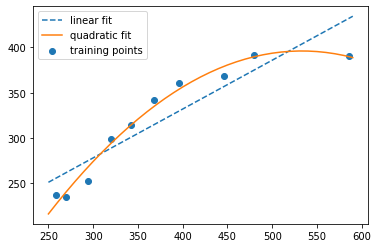

In [36]:
plt.scatter(X, y, label='training points')
plt.plot(X_fit, y_lin_fit,label='linear fit', linestyle='--')
plt.plot(X_fit, y_quad_fit,label='quadratic fit')
plt.legend(loc='upper left')
plt.show()

In [37]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)
print('Training MSE linear: %.3f, quadratic: %.3f' % (mean_squared_error(y, y_lin_pred),mean_squared_error(y, y_quad_pred)))
print('Training R^2 linear: %.3f, quadratic: %.3f' % (r2_score(y, y_lin_pred),r2_score(y, y_quad_pred)))

Training MSE linear: 569.780, quadratic: 61.330
Training R^2 linear: 0.832, quadratic: 0.982


## Modeling nonlinear relationships in the Housing dataset

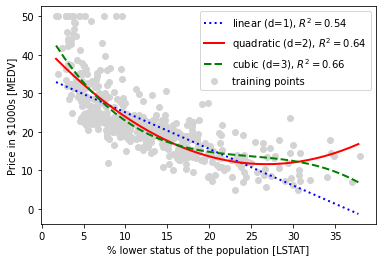

In [38]:
X = df[['LSTAT']].values
y = df['MEDV'].values
regr = LinearRegression()
# create quadratic features
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)
# fit features
X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]
regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))
regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))
regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))
# plot results
plt.scatter(X, y, label='training points', color='lightgray')
plt.plot(X_fit, y_lin_fit,label='linear (d=1), $R^2=%.2f$' % linear_r2,color='blue',lw=2,linestyle=':')
plt.plot(X_fit, y_quad_fit,label='quadratic (d=2), $R^2=%.2f$' % quadratic_r2,color='red',lw=2,linestyle='-')
plt.plot(X_fit, y_cubic_fit,label='cubic (d=3), $R^2=%.2f$' % cubic_r2,color='green',lw=2,linestyle='--')
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='upper right')
plt.show()

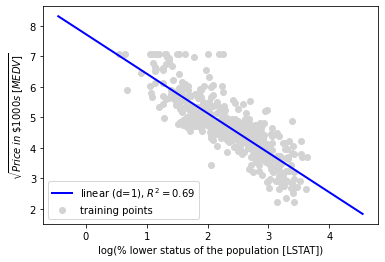

In [39]:
# transform features
X_log = np.log(X)
y_sqrt = np.sqrt(y)
# fit features
X_fit = np.arange(X_log.min()-1,X_log.max()+1, 1)[:, np.newaxis]
regr = regr.fit(X_log, y_sqrt)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y_sqrt, regr.predict(X_log))
# plot results
plt.scatter(X_log, y_sqrt,label='training points',color='lightgray')
plt.plot(X_fit, y_lin_fit,label='linear (d=1), $R^2=%.2f$' % linear_r2,color='blue',lw=2)
plt.xlabel('log(% lower status of the population [LSTAT])')
plt.ylabel('$\sqrt{Price \; in \; \$1000s \; [MEDV]}$')
plt.legend(loc='lower left')
plt.show()

## Dealing with nonlinear relationships using random forests

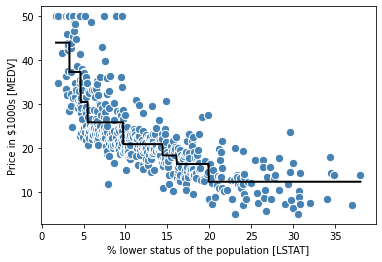

In [40]:
from sklearn.tree import DecisionTreeRegressor
X = df[['LSTAT']].values
y = df['MEDV'].values
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)
sort_idx = X.flatten().argsort()
lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000s [MEDV]')
plt.show()

## Random forest regression

In [41]:
X = df.iloc[:, :-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test =train_test_split(X, y,test_size=0.4,random_state=1)
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=1000,criterion='mse',random_state=1,n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred),mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
r2_score(y_train, y_train_pred),
r2_score(y_test, y_test_pred)))

MSE train: 1.644, test: 11.085
R^2 train: 0.979, test: 0.877


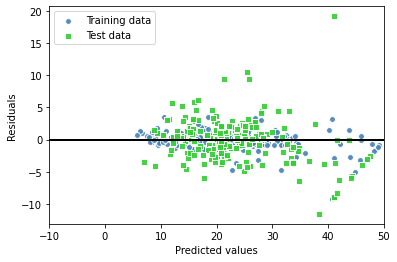

In [42]:
plt.scatter(y_train_pred,y_train_pred - y_train,c='steelblue',edgecolor='white',marker='o',s=35,alpha=0.9,label='Training data')
plt.scatter(y_test_pred,y_test_pred - y_test,c='limegreen',edgecolor='white',marker='s',s=35,alpha=0.9,label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='black')
plt.xlim([-10, 50])
plt.show()